![](https://moneylion.nyc3.cdn.digitaloceanspaces.com/wp-content/uploads/2023/01/06170512/Untitled-design-88.webp)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################
stock_data = yf.download('NVDA') # you can choose whatever stockticker you want

num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

# Here I choose to only use the last 3 years of stock data 
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about 
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

c:\Users\nuosv\AppData\Local\pypoetry\Cache\virtualenvs\stock-prediction-project-SlYgHs5j-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[*********************100%***********************]  1 of 1 completed


# XGBOOST

In [2]:
df_xgb = stock_data.copy()

In [3]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [4]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-08-28 01:38:28,300] A new study created in memory with name: no-name-8a1d74d4-927a-4dfc-a317-b680dbe16f66
[I 2024-08-28 01:38:29,342] Trial 0 finished with value: 1.8462692788893822 and parameters: {'n_estimators': 901, 'max_depth': 3, 'learning_rate': 0.012607281287091812, 'subsample': 0.8399692372858786, 'colsample_bytree': 0.9769559886700367, 'reg_alpha': 7.198337070054585, 'reg_lambda': 9.482396296507293}. Best is trial 0 with value: 1.8462692788893822.
[I 2024-08-28 01:38:29,550] Trial 1 finished with value: 1.6572734763198282 and parameters: {'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.061534886339557386, 'subsample': 0.8913360157626006, 'colsample_bytree': 0.8543550344967032, 'reg_alpha': 5.923132026638185, 'reg_lambda': 4.9175223602098885}. Best is trial 1 with value: 1.6572734763198282.
[I 2024-08-28 01:38:30,119] Trial 2 finished with value: 1.5770772283999734 and parameters: {'n_estimators': 630, 'max_depth': 4, 'learning_rate': 0.024902783044862768, 'sub

Best trial:
  Value: 1.372087567218385
  Params: 
    n_estimators: 378
    max_depth: 9
    learning_rate: 0.048625018130061017
    subsample: 0.748864337409242
    colsample_bytree: 0.7304960398664389
    reg_alpha: 2.512034407138532
    reg_lambda: 2.853286107392548
Test RMSE: 1.372087567218385


## Evaluate

In [5]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 3.292380717157408% 


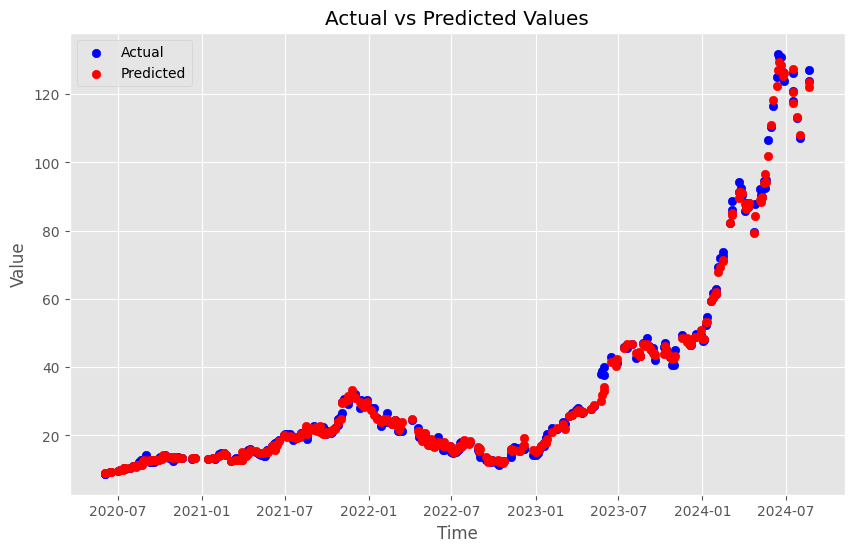

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

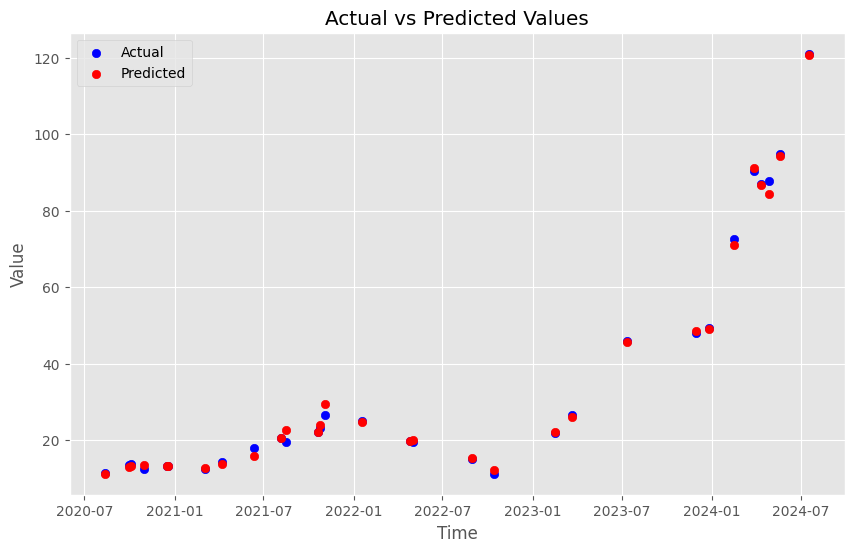

In [7]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

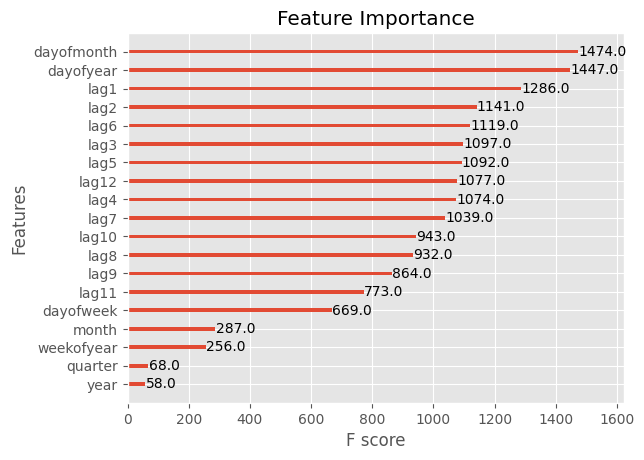

In [8]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

## Predict In The Future

In [9]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

In [10]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [11]:
future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))

In [12]:
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-08-27,123.235092
2024-08-28,121.470222
2024-08-29,119.120491
2024-08-30,116.018028
2024-08-31,116.404137
2024-09-01,108.536636
2024-09-02,108.338875
2024-09-03,110.025047
2024-09-04,125.041161
2024-09-05,109.123718


# Communicate the results

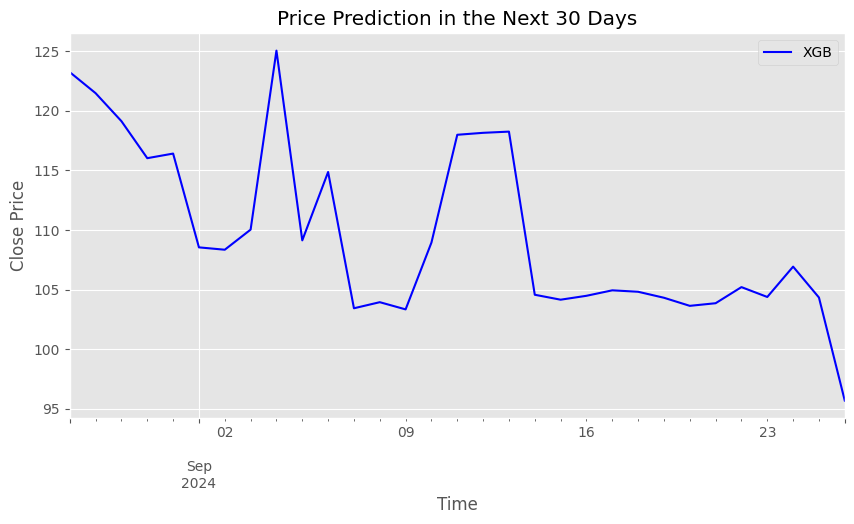

In [13]:
fig, ax  = plt.subplots(figsize=(10,5))
prediction_xgb.plot(color = 'blue',ax=ax)
plt.legend(['XGB'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [14]:
print(f"XGB Acc : {100-xgb_loss}")

XGB Acc : 96.70761928284259
